**ANSWERS**

**QUESTION 1(a):**

After exploring the data, it can be concluded that an AOV of 3145.13 was calculated just by taking the average of order_amount for all the orders. Because there are a few orders which are huge, they end up impacting the overall mean of order_amount, which is 3145.13. 

**QUESTION 1(b):**

- It is clear in the data that there exist a few extreme outliers in terms of order_amount. We also know that shops 42 & 78 are the shops that are the most involved with these outlier data points. These 2 ships account for ~90% of the total order_amount of the whole dataset. Without knowing whether these extreme data points are actually true data or not, it is hard to scientifically decide whether we should completely ignore them or somehow use them in the calculation of the AOV.

- Based on the point above, it is practical and robust to use the median of the order_amount as a proxy for the AOV.

- Another alternative would be to use a segmented AOV such as AOV per shop or per user, so instead of reporting 1 AOV, we can report an AOV for each store or each user, however for simplicity I have decided to report the median of order_amount.

**QUESTION 1(c):**

Median Order Value = 284 Dollars



**QUESTION 2(a):**

**Answer:** 54

**Query:**

SELECT COUNT(*) FROM [Shippers]

LEFT JOIN [Orders]

ON Orders.ShipperID = Shippers.ShipperID

WHERE Shippers.ShipperName = 'Speedy Express'

**QUESTION 2(b):**

**Answer:** Peacock

**Query:**

SELECT COUNT(*) AS NUM_ORDERS, Orders.EmployeeID,

Employees.LastName FROM [Orders]

LEFT JOIN [Employees]

ON Orders.EmployeeID = Employees.EmployeeID

GROUP BY Orders.EmployeeID

ORDER BY NUM_ORDERS DESC

LIMIT 1

**QUESTION 2(c):**

**Answer:** Boston Crab Meat

**Query:**

SELECT SUM(OD.Quantity) AS NUM_ORDERS, P.ProductName FROM 

[Customers] AS C

LEFT JOIN Orders AS O 

ON O.CustomerID = C.CustomerID

LEFT JOIN OrderDetails AS OD

ON OD.OrderID = O.OrderID

LEFT JOIN Products as P

ON P.ProductID = OD.ProductID

WHERE C.Country = 'Germany'

GROUP BY ProductName

ORDER BY NUM_ORDERS DESC 

LIMIT 1

**QUESTION 1 ANALYSIS**

In [1]:
import numpy as np, pandas as pd, seaborn as sns # import relevant libraries

In [2]:
df = pd.read_csv('Downloads/2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv') # load data

**EXPLORATORY DATA ANALYSIS**

In [4]:
df.head() # view a small sample

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


- Notice that each order is associated to a user and a shop
- An order can contain multiple items
- An order can be executed using different payment methods

In [6]:
df.shape # check size of data

(5000, 7)

In [8]:
df['order_id'].nunique() # number of unique order_id's

5000

In [9]:
df['shop_id'].nunique() # number of unique shop_id's

100

In [10]:
df['user_id'].nunique() # number of unique user_id's

301

In [12]:
df['payment_method'].nunique() # number of unique payment methods

3

In [13]:
df.describe() # check summary statistics for each numeric column

,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


- order_amount has a mean of ~3145.13, which is equal to the AOV mentioned in the question. From this we can conclude that the AOV is calculated as the mean of the order_amount column
- order_amount's median differs alot from the mean, suggesting skewness and outliers. Its standard deviation suggests the same.
- order_amount has a very big range

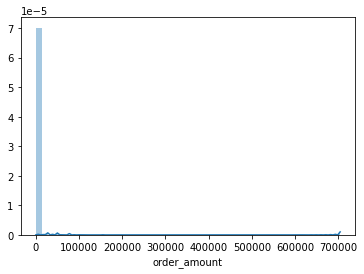

In [15]:
sns.distplot(df['order_amount']) # plot histogram

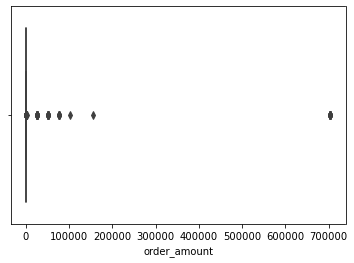

In [16]:
sns.boxplot(df['order_amount']) # plot boxplot

- Notice in the histogram that most of the values are on the lower end of the range, and there are relatively very few large values, clearly suggesting outliers. These outliers seem to be the reason why the AOV is calculated to be so high
- Since the range is so big, and there are huge outliers, we need to explore other methods to calculate a variant of the AOV...we can drop the outliers or use a robust summary metric such as the median, but first we need to check the properties of these outliers

In [28]:
# view the top 10 shops by average order_amount
df.groupby('shop_id')['order_amount'].agg('mean').sort_values(ascending=False).iloc[:10]

shop_id
42    235101.490196
78     49213.043478
50       403.545455
90       403.224490
38       390.857143
81       384.000000
6        383.508475
89       379.147541
33       376.275000
51       361.804348
Name: order_amount, dtype: float64

- shops 42 and 78 are the ones that appear to be extreme outliers, let's explore how much order value they generate out of the total order value of the dataset

In [44]:
dd = df.groupby('shop_id')['order_amount'].agg('sum').sort_values(ascending=False)
dd.iloc[:2].sum()/dd.sum()

0.9064162730419875

Shops 42 & 78 account for ~90% of the total order value of the whole dataset!

**CONCLUSION**
- We can continue to do a similar analysis for the users too, but however without knowing whether these extreme data points are actually true or not, it is hard to decide whether we should completely ignore them or somehow use them in the calculation of the AOV.
- Based on the point above, it is practical and robust to use the median of the order_amount as a proxy for the AOV.

In [45]:
df['order_amount'].median()

284.0